In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!unzip /content/gdrive/MyDrive/NeuralNetwork/data.zip > /dev/null

replace data/Test/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


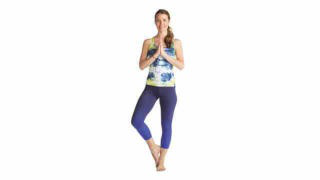

In [3]:
import tensorflow as tf
img = tf.keras.preprocessing.image.load_img('data/Train/Yoga_236.jpg')
img

In [4]:
import tensorflow as tf
from tensorflow.keras import layers


data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [5]:
import os
from keras.utils import to_categorical
import tensorflow as tf
import numpy as np
from random import shuffle

train_data = []

for i in os.listdir('/content/data/Train'):
  img = tf.keras.preprocessing.image.load_img(os.path.join('/content/data/Train',i),target_size =(224,224,3))
  img = tf.keras.utils.img_to_array(img)

  augmented_image = data_augmentation(img)
  augmented_image =tf.keras.utils.img_to_array(augmented_image)

  image_label = i.split('_')[0]

  train_data.append((img, image_label))
  train_data.append((augmented_image, image_label))


shuffle(train_data)

train_images = []
train_labels = []

for i in range(len(train_data)):
  train_images.append(train_data[i][0])
  train_labels.append(train_data[i][1])

classes = ["Basketball", "Football", "Rowing", "Swimming", "Tennis", "Yoga"]

mapping = {}
for i in range(len(classes)):
  mapping[classes[i]] = i

# integer representation
for i in range(len(train_labels)):
  train_labels[i] = mapping[train_labels[i]]

encoded_labels = to_categorical(train_labels)

train_images = np.array(train_images) 


In [6]:
import os
from keras.utils import to_categorical
import tensorflow as tf
import numpy as np
train_images = []
train_labels = []
for i in os.listdir('/content/data/Train'):
  img = tf.keras.preprocessing.image.load_img(os.path.join('/content/data/Train',i),target_size =(224,224,3))
  img = tf.keras.utils.img_to_array(img)

  image_label = i.split('_')[0]
  train_images.append(img)
  train_labels.append(image_label)

train_images = np.array(train_images) 
print(train_images.shape)
classes = ["Basketball", "Football", "Rowing", "Swimming", "Tennis", "Yoga"]

mapping = {}
for i in range(len(classes)):
  mapping[classes[i]] = i

# integer representation
for i in range(len(train_labels)):
  train_labels[i] = mapping[train_labels[i]]

encoded_labels = to_categorical(train_labels)


(1681, 224, 224, 3)


In [18]:
import os

test_images = []
test_images_names = []
for i in os.listdir('/content/data/Test'):
  img = tf.keras.preprocessing.image.load_img(os.path.join('/content/data/Test',i),target_size =(224,224,3))
  img = tf.keras.utils.img_to_array(img)
  test_images.append(img)
  test_images_names.append(i)

test_images = np.array(test_images) 

In [10]:
import tensorflow as tf
import keras

from tensorflow.keras.layers import Input,Dense,Conv2D,Add
from tensorflow.keras.layers import SeparableConv2D,ReLU
from tensorflow.keras.layers import BatchNormalization,MaxPool2D,ZeroPadding2D
from tensorflow.keras.layers import GlobalAvgPool2D
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D

from tensorflow.keras import Model
from keras.initializers import glorot_uniform

# creating the Conv-Batch Norm block

def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

base_model = ResNet50(input_shape=(224, 224, 3))

headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense(6,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

model = Model(inputs=base_model.input, outputs=headModel)

model.compile(loss = keras.losses.categorical_crossentropy, optimizer= 'adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d_1[0][0]']       
                                )                                                           

In [16]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max')

model.fit(train_images, encoded_labels , validation_split=0.2, epochs = 100, batch_size = 64, steps_per_epoch = train_images.shape[0]//64, callbacks = [es,mc], verbose = 1)

Epoch 1/100
26/26 [==============================] - 52s 2s/step - loss: 1.1570 - accuracy: 0.5697 - val_loss: 1.7467 - val_accuracy: 0.3056
Epoch 2/100
26/26 [==============================] - 24s 922ms/step - loss: 1.0074 - accuracy: 0.6478 - val_loss: 1.6421 - val_accuracy: 0.3561
Epoch 3/100
26/26 [==============================] - 21s 805ms/step - loss: 0.9106 - accuracy: 0.6893 - val_loss: 1.5259 - val_accuracy: 0.4154
Epoch 4/100
26/26 [==============================] - 20s 783ms/step - loss: 0.7682 - accuracy: 0.7338 - val_loss: 1.4312 - val_accuracy: 0.4540
Epoch 5/100
26/26 [==============================] - 20s 784ms/step - loss: 0.6563 - accuracy: 0.7668 - val_loss: 1.1590 - val_accuracy: 0.5846
Epoch 6/100
26/26 [==============================] - 20s 790ms/step - loss: 0.5651 - accuracy: 0.8035 - val_loss: 1.0218 - val_accuracy: 0.6499
Epoch 7/100
26/26 [==============================] - 21s 801ms/step - loss: 0.4894 - accuracy: 0.8191 - val_loss: 0.9806 - val_accuracy: 0.

In [19]:
y_predictions = model.predict(test_images)
print(y_predictions)

22/22 [==============================] - 5s 121ms/step
[[3.25094094e-04 6.06436864e-04 3.67187982e-04 7.53983185e-02
  5.05107880e-01 9.99862313e-01]
 [2.99717303e-05 3.59151414e-07 9.90975559e-01 1.95771005e-04
  1.63825155e-06 8.64701200e-10]
 [1.90017209e-03 3.35280806e-01 8.79330328e-05 6.87111533e-05
  9.65936422e-01 8.78943945e-04]
 ...
 [5.77819776e-07 9.85506058e-01 3.44572240e-03 1.35058992e-10
  2.17809884e-05 2.46359253e-08]
 [1.02400547e-03 4.68513841e-04 1.35546755e-02 5.46280555e-02
  9.99888420e-01 2.92212125e-02]
 [7.07279746e-09 3.74361974e-07 2.14151223e-03 9.97866333e-01
  4.80718305e-03 1.83575060e-02]]


In [20]:
result = []
for i in y_predictions:
  result.append(np.argmax(i))

import csv
with open('result.csv', 'w', newline='') as csv_file:
      fieldnames = ['image_name', 'label']
      writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
      writer.writeheader()
      for i in range(len(result)):
          writer.writerow({'image_name': test_images_names[i], 'label': result[i]})

In [21]:
model.save('resnet.h5')